# Bump Hunt with baseline features and BDT setup

For these plots, a bump hunt is performed with the original LHCO R&D dataset only. Sliding windows are all 0.4TeV wide and move by 0.1TeV. These runs use k-fold cross validation at k=5. 

The systematics are estimated as 
\begin{equation}
    \mathcal{S}= \frac{N'-\varepsilon_B (1+\alpha) N_{SR}}{\sqrt{\sigma_{stat}^2+\sigma_{sys}^2}}
\end{equation}
where $\alpha$ is a relative systematic offset caused by the systematic differences between CR and SR bkg.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BH_percentiles = [1e-2, 1e-3, 1e-4]
general_directory = "/hpcwork/zu992399/bumphunt_paper/"
general_directory_work = "/work/zu992399/bumphunt_paper/"
plotting_direc = "plots/sig_formula/"

min_error = -0.5
max_error = 2.2

min_sig = -1
max_sig = 15
max_sig_no = 5.5

In [3]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
#plt.rcParams['text.usetex'] = True
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16 
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = True

In [4]:
def calc_and_apply_threshold(samples_preds, data_preds, labels, efficiency):
    eps = np.quantile(samples_preds, 1-efficiency, method="nearest")
    if efficiency == 1:
        eps=0.
    N_samples_after = np.size(np.where(samples_preds>=eps))
    N_samples = len(samples_preds)
    N_after = np.size(np.where(data_preds>=eps))#-1/3
    N = len(data_preds)
    N_bkg = np.size(np.where(data_preds[labels==0]>eps))
    N_sig = np.size(np.where(data_preds[labels==1]>eps))
    return N_samples_after, N_samples, N_after, N, N_bkg, N_sig

def sig(N, b, err):
    s = N - b
    ln1 = N * (b+err**2) / (b**2+N*err**2)
    ln1 = 2 * N * np.log(ln1)

    ln2 = 1 + err**2 * s / b / (b+err**2)
    ln2 = 2 * b**2 / err**2 * np.log(ln2)

    return np.sqrt(ln1 - ln2)
    

def significances(N_after, N, N_sig, N_bkg, N_samples_after, eff, err):
    N_b_exp = eff*N*(1+err)
    stat_err = np.sqrt(1/N_b_exp+1/N_samples_after)
    samples_err = np.sqrt(1/N_samples_after)
    formular_err = N_b_exp * np.sqrt(samples_err**2+err**2)
    full_err = N_b_exp * np.sqrt(stat_err**2+err**2)
    results = sig(N_after, N*eff, 0)#(N_after-N*eff)/stat_err
    rel_results = sig(N_after, N_b_exp, N_b_exp*err)#(N_after - N_b_exp)/full_err
    true_results = N_sig/np.sqrt(N_bkg)
    rel_error = (N_after-N*eff)/(eff*N)
    return results, rel_results, true_results, rel_error, stat_err

In [5]:
def bump_hunt_single_window(folder, window, err=None, runs=10, turn_around=False):
	results = np.zeros((len(BH_percentiles),runs))
	true_results =  np.zeros((len(BH_percentiles),runs))
	rel_results =  np.zeros((len(BH_percentiles),runs))
	rel_error =  np.zeros((len(BH_percentiles),runs))
	stat_error = np.zeros((len(BH_percentiles),runs))

	arr_shape = (5,len(BH_percentiles), runs)
	N_samples_after = np.zeros(arr_shape)
	N_samples = np.zeros(arr_shape)
	N_after = np.zeros(arr_shape)
	N = np.zeros(arr_shape)
	N_bkg = np.zeros(arr_shape)
	N_sig = np.zeros(arr_shape)
	N_bkg_orig = 0

	for fold in range(5): 
		f = folder +"fold"+str(fold)+"/"
		if turn_around: 
			samples_preds = np.load(f+"test_preds.npy")
			#print(samples_preds.shape)
			samples_preds = samples_preds[-10:]
			data_preds = np.load(f+"samples_preds.npy")[-10:]
			labels = np.zeros((data_preds.shape[1]))
		else:
			samples_preds = np.load(f+"samples_preds.npy")
			#print(samples_preds.shape)
			samples_preds = samples_preds[-10:]
			data_preds = np.load(f+"test_preds.npy")[-10:]
			labels = np.load(f+"Y_test.npy")
		N_bkg_orig += np.shape(data_preds[:,labels==0])[-1]
		for j, perc in enumerate(BH_percentiles):
			for i in range(len(samples_preds)):
				N_samples_after[fold, j, i], N_samples[fold, j, i], N_after[fold, j, i], N[fold, j, i], N_bkg[fold, j, i], N_sig[fold, j, i] = calc_and_apply_threshold(samples_preds[i], data_preds[i], labels, perc)
	N_samples_after = np.sum(N_samples_after, axis=0)
	N_samples = np.sum(N_samples, axis=0)
	N_after = np.sum(N_after, axis=0)
	N = np.sum(N, axis=0)
	N_bkg = np.sum(N_bkg, axis=0)
	N_sig = np.sum(N_sig, axis=0)
	eff_eff = N_samples_after/N_samples

	if err is None:
		err = np.zeros(len(BH_percentiles))
		
	for j, perc in enumerate(BH_percentiles):
		results[j], rel_results[j], true_results[j], rel_error[j], stat_error[j] = significances(N_after[j], N[j], N_sig[j], N_bkg[j], N_samples_after[j], eff_eff[j], err[j])

	return results, rel_results, true_results, rel_error, stat_error

def bump_hunt(folder, err=None, runs=10, turn_around=False):
	print(folder)

	results = np.zeros((len(BH_percentiles),9,runs))
	true_results =  np.zeros((len(BH_percentiles),9,runs))
	rel_results =  np.zeros((len(BH_percentiles),9,runs))
	rel_error =  np.zeros((len(BH_percentiles),9,runs))
	exp =  np.zeros((len(BH_percentiles),9,runs))

	for window in range(9):
		results[:,window], rel_results[:,window], true_results[:,window], rel_error[:,window], exp[:,window] = bump_hunt_single_window(folder+"window"+str(window+1)+"_", window, err=err, runs=runs, turn_around=turn_around)
	
	return results, rel_results, true_results, rel_error, exp

In [6]:
colors_results = ["blue", "red", "orange"]
#colors_true = ["dodgerblue", "orange", "lilac"]

def plotting(rel_results, true_results, name, min=None, max=None):
    plt.figure()
    x = range(1,10)
    plt.axhline(5, color="black", linestyle="--", label="5$\sigma$")
    plt.axhline(0, color="black", label="0$\sigma$")
    for j, perc in enumerate(BH_percentiles):
        plt.errorbar(x, np.mean(rel_results[j],axis=-1), yerr = np.std(rel_results[j], axis=-1,ddof=1), label=r"$\epsilon_B$="+str(perc), fmt='o', color=colors_results[j])
        #plt.errorbar(x, np.mean(true_results[j],axis=-1), yerr = np.std(rel_results[j], axis=-1,ddof=1), fmt='o', color=colors_true[j])

    if min is not None and max is not None:
        plt.ylim(min,max)
    elif min is not None:
        plt.ylim(bottom=min)
    elif max is not None:
        plt.ylim(top=max)

    plt.grid()
    plt.ylabel(r"Significance")
    plt.xlabel(r"Sliding window #")
    plt.legend(loc="upper right")
    plt.subplots_adjust(bottom=0.15, left= 0.19, top = 0.92, right = 0.965)

    plt.savefig(plotting_direc+name+".pdf")
    plt.savefig(plotting_direc+name+".png")


def plotting_error(rel_results, name, min=None, max=None):
    plt.figure()
    x = range(1,10)
    plt.axhline(0, color="black")
    for j, perc in enumerate(BH_percentiles):
        plt.errorbar(x, np.mean(rel_results[j],axis=-1), yerr = np.std(rel_results[j], axis=-1,ddof=1), label=r"$\epsilon_B$="+str(perc), fmt='o', color=colors_results[j])
        plt.plot(x, np.max(rel_results[j], axis=-1), 'x', color=colors_results[j])
        #plt.errorbar(x, np.mean(true_results[j],axis=-1), yerr = np.std(rel_results[j], axis=-1,ddof=1), fmt='o', color=colors_true[j])
        
    plt.grid()
    plt.ylabel(r"R (relative systematic)")
    plt.xlabel(r"Sliding window #")
    plt.legend(loc="upper right")
    plt.subplots_adjust(bottom=0.15, left= 0.19, top = 0.92, right = 0.965)
    if min is not None and max is not None:
        plt.ylim(min,max)
    elif min is not None:
        plt.ylim(bottom=min)
    elif max is not None:
        plt.ylim(top=max)

    plt.savefig(plotting_direc+name+"_error.pdf")
    plt.savefig(plotting_direc+name+"_error.png")

## CWoLa

First, the systematic offset is determined as a constant relative offset in $m_{JJ}$ with 
\begin{equation}
    \alpha = \frac{N'-\varepsilon_B N_{SR}}{\varepsilon_B N_{SR}}
\end{equation}
based on 10 runs without signal.

We estimate our systematic error conservatively with $\sigma_{sys}=\alpha\varepsilon_B N_{SR}.$ 

/hpcwork/zu992399/bumphunt_paper/cwola_without/


/tmp/zu992399/login23-1_162331/ipykernel_182202/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_162331/ipykernel_182202/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


alpha = [0.13747762 0.16111538 0.19623152]
alpha_std = [0.07155704 0.16644098 0.37281859]
stat = [0.04069738 0.12570735 0.34592745]


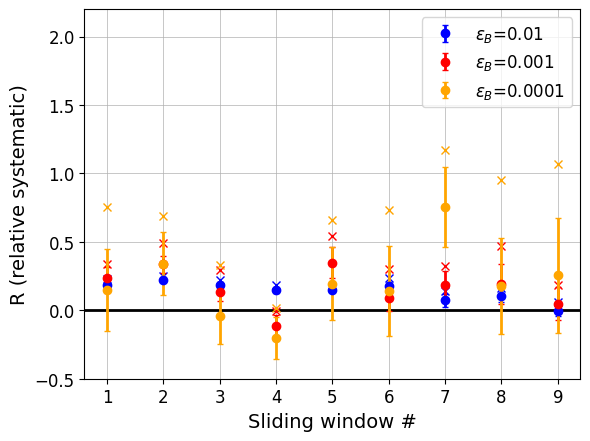

In [7]:
folder = general_directory+"cwola_without/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder)
cwola_error = np.mean(rel_error,axis=(1,2))
plotting_error(rel_error, "cwola_without", min=min_error, max=max_error)
cwola_stat = np.mean(exp,axis=(1,2))
cwola_sys = np.std(rel_error, axis=(1,2))
print("alpha =", cwola_error)
print("alpha_std =", np.std(rel_error, axis=(1,2)))
print("stat =", cwola_stat)

We test our systematic error by considering 100 independent runs (on the same dataset).

Results show a good agreement with the null hypothesis with a slightly overestimated error that is in the correct order of magnitude.

We now look at an analysis with signal: 

/hpcwork/zu992399/bumphunt_paper/cwola_norm/


/tmp/zu992399/login23-1_162331/ipykernel_182202/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_162331/ipykernel_182202/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


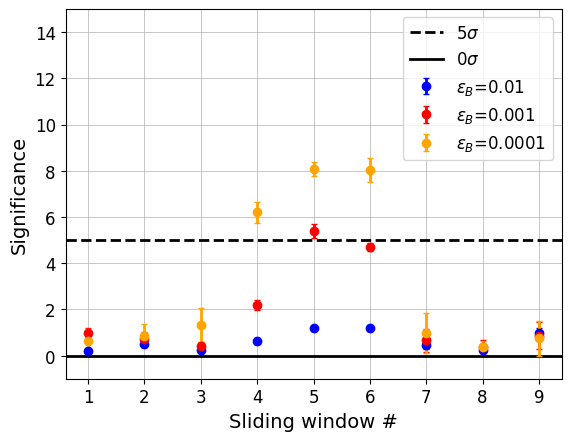

In [8]:
folder = general_directory+"cwola_norm/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cwola_error)
plotting(rel_results, true_results, "cwola_norm", min=min_sig, max = max_sig)

/hpcwork/zu992399/bumphunt_paper/cwola_herwig_without_2/


/tmp/zu992399/login23-1_162331/ipykernel_182202/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_162331/ipykernel_182202/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


alpha = [0.13954379 0.11473376 0.04827641]
alpha_std = [0.04539765 0.18010538 0.31591527]
sys_err/stat_err = [0.0405328  0.12560472 0.34561306]


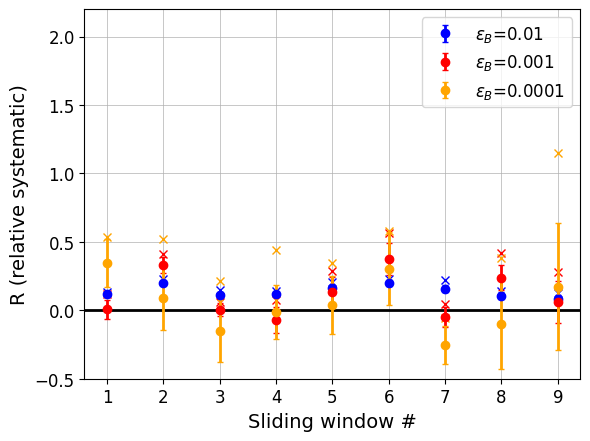

In [9]:
folder = general_directory+"cwola_herwig_without_2/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder)
cwola_herwig_error = np.mean(rel_error,axis=(1,2))

plotting_error(rel_error, "cwola_without_herwig", min=min_error, max=max_error)
cwola_herwig_stat = np.mean(exp,axis=(1,2))
cwola_herwig_sys = np.std(rel_error, axis=(1,2))
print("alpha =",cwola_herwig_error)
print("alpha_std =", np.std(rel_error, axis=(1,2)))
print("sys_err/stat_err =",cwola_herwig_stat)

/hpcwork/zu992399/bumphunt_paper/cwola_without/


/tmp/zu992399/login23-1_162331/ipykernel_182202/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_162331/ipykernel_182202/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


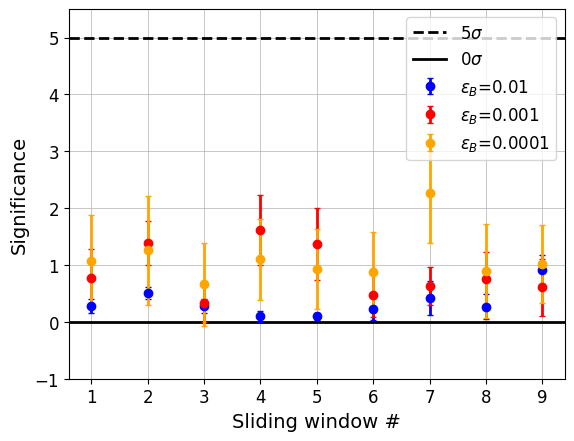

In [10]:
folder = general_directory+"cwola_without/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cwola_herwig_error)
plotting(rel_results, true_results, "cwola_without_pythia_herwig", min=min_sig, max = max_sig_no)

/hpcwork/zu992399/bumphunt_paper/cwola_norm/


/tmp/zu992399/login23-1_162331/ipykernel_182202/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_162331/ipykernel_182202/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


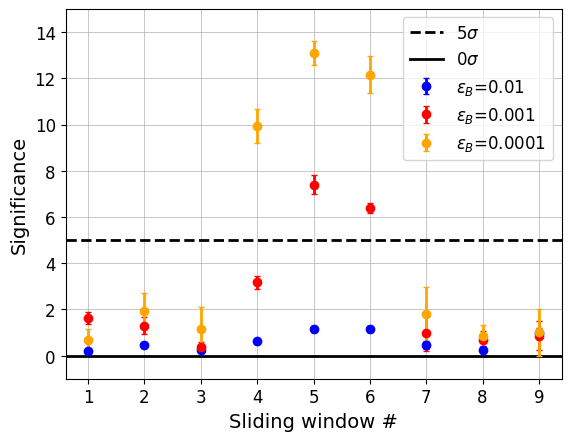

In [11]:
folder = general_directory+"cwola_norm/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cwola_herwig_error)
plotting(rel_results, true_results, "cwola_norm_pythia_herwig", min=min_sig, max = max_sig)

/hpcwork/zu992399/bumphunt_paper/cwola_baseline_750/


/tmp/zu992399/login23-1_162331/ipykernel_182202/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_162331/ipykernel_182202/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


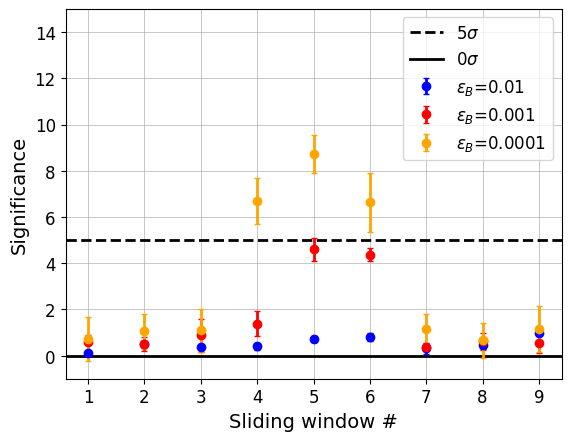

In [12]:
folder = general_directory+"cwola_baseline_750/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cwola_herwig_error)
plotting(rel_results, true_results, "cwola_500_pythia_herwig", min=min_sig, max = max_sig)

## CATHODE

We now perform the same analysis for CATHODE. We do not rerun the DE for different runs. First 10 runs without signal to estimate the systematic offset and error.

/hpcwork/zu992399/bumphunt_paper/cathode_without_randDE_avg/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


alpha = [0.1349527  0.24993543 0.80205   ]
alpha_std = [0.07316377 0.12743923 0.59473036]
stat_error = [0.02942294 0.093033   0.29394902]


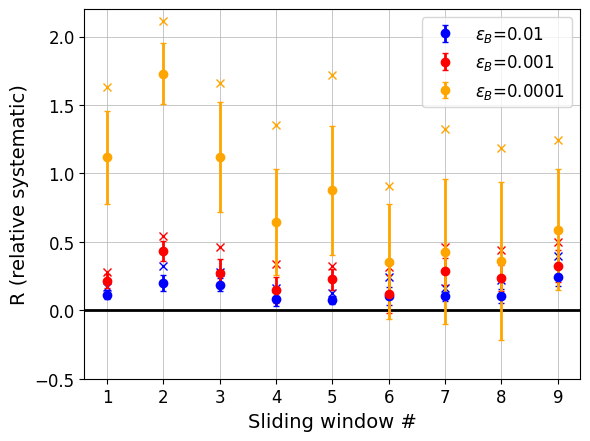

In [37]:
folder = general_directory+"cathode_without_randDE_avg/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder)
cathode_error = np.mean(rel_error,axis=(1,2))
plotting_error(rel_error, "cathode_without", min=min_error, max=max_error)
cathode_stat = np.mean(exp,axis=(1,2))
cathode_sys = np.std(rel_error, axis=(1,2))
print("alpha =",cathode_error)
print("alpha_std =", np.std(rel_error, axis=(1,2)))
print("stat_error =",cathode_stat)

/hpcwork/zu992399/bumphunt_paper/cathode_without_Joep/


/tmp/zu992399/login23-1_7353/ipykernel_177462/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_7353/ipykernel_177462/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


alpha = [0.13712146 0.33959901 0.91495694]
alpha_std = [0.03402532 0.12597822 0.47019764]
stat_error = [0.02858809 0.09039608 0.28548244]


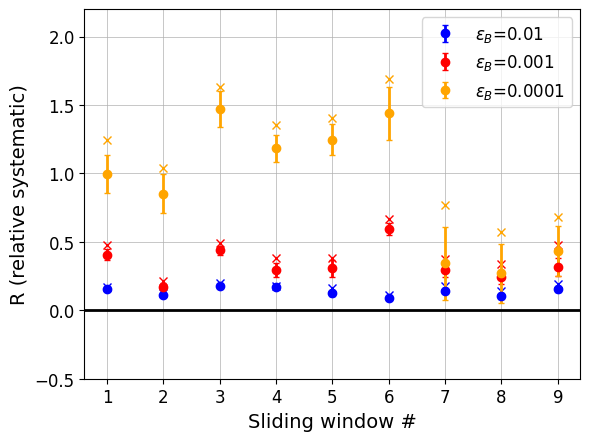

In [7]:
folder = general_directory+"cathode_without_Joep/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder)
cathode_error = np.mean(rel_error,axis=(1,2))
plotting_error(rel_error, "cathode_without", min=min_error, max=max_error)
cathode_stat = np.mean(exp,axis=(1,2))
cathode_sys = np.std(rel_error, axis=(1,2))
print("alpha =",cathode_error)
print("alpha_std =", np.std(rel_error, axis=(1,2)))
print("stat_error =",cathode_stat)

/hpcwork/zu992399/bumphunt_paper/cathode_without_Joep_2/


/tmp/zu992399/login23-1_216526/ipykernel_88572/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_216526/ipykernel_88572/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


alpha = [0.12334444 0.25873073 0.82282929]
alpha_std = [0.04209975 0.12170089 0.42330206]
stat_error = [0.02858808 0.09039607 0.28548348]


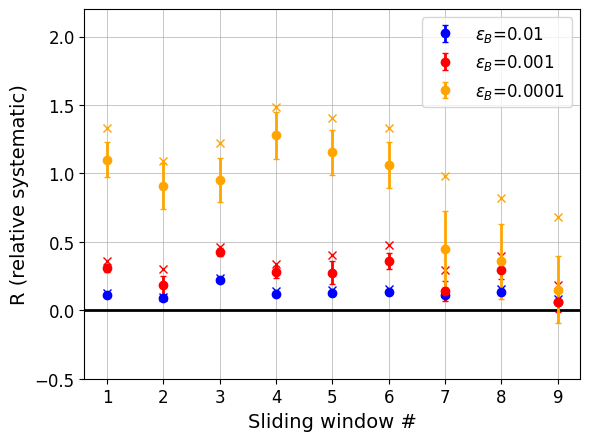

In [7]:
folder = general_directory+"cathode_without_Joep_2/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder)
cathode_error = np.mean(rel_error,axis=(1,2))
plotting_error(rel_error, "cathode_without", min=min_error, max=max_error)
cathode_stat = np.mean(exp,axis=(1,2))
cathode_sys = np.std(rel_error, axis=(1,2))
print("alpha =",cathode_error)
print("alpha_std =", np.std(rel_error, axis=(1,2)))
print("stat_error =",cathode_stat)

/hpcwork/zu992399/bumphunt_paper/cathode_norm_avg_oversampling4/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


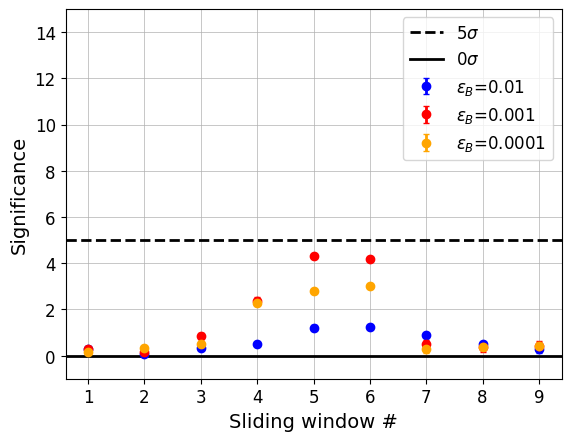

In [15]:
folder = general_directory+"cathode_norm_avg_oversampling4/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cathode_error)
plotting(rel_results, true_results, "cathode_norm", min=min_sig, max = max_sig)

/work/zu992399/bumphunt_paper/cathode_without_Herwig_randDE_avg_2/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


alpha = [0.09074848 0.15569776 0.27088978]
alpha_std = [0.0368571  0.10953688 0.37417663]
stat_error = [0.02928605 0.09260008 0.29255154]


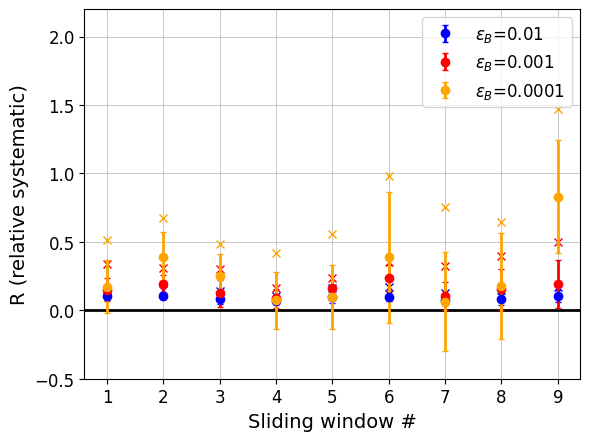

In [38]:
folder = general_directory_work+"cathode_without_Herwig_randDE_avg_2/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder)
cathode_herwig_error = np.mean(rel_error,axis=(1,2))
plotting_error(rel_error, "cathode_without_herwig", min=min_error, max=max_error)
cathode_herwig_stat = np.mean(exp,axis=(1,2))
cathode_herwig_sys = np.std(rel_error, axis=(1,2))
print("alpha =",cathode_herwig_error)
print("alpha_std =", np.std(rel_error, axis=(1,2)))
print("stat_error =",cathode_herwig_stat)

/hpcwork/zu992399/bumphunt_paper/cathode_without_randDE_avg/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


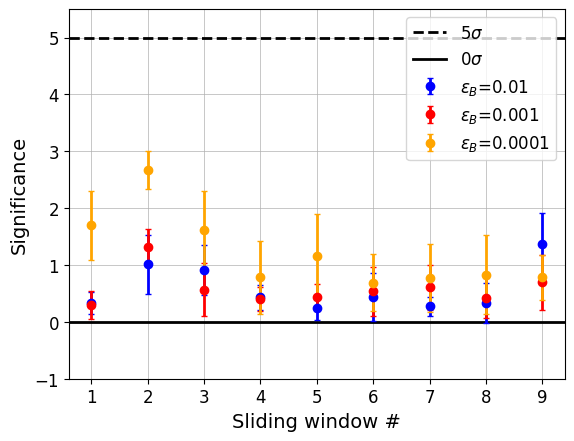

In [17]:
folder = general_directory+"cathode_without_randDE_avg/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cathode_herwig_error)
plotting(rel_results, true_results, "cathode_without_pythia_herwig", min=min_sig, max = max_sig_no)

/hpcwork/zu992399/bumphunt_paper/cathode_norm_avg_oversampling4/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


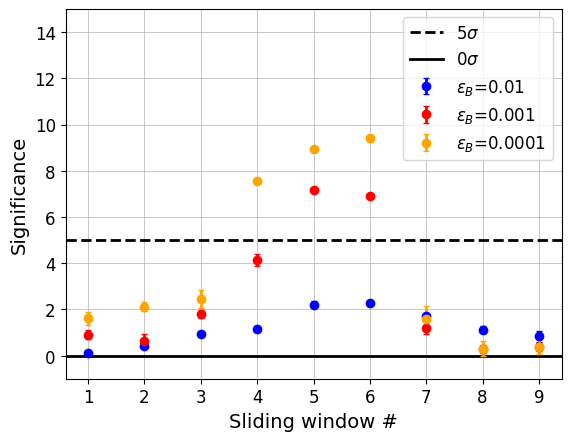

In [18]:
folder = general_directory+"cathode_norm_avg_oversampling4/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cathode_herwig_error)
plotting(rel_results, true_results, "cathode_norm_pythia_herwig", min=min_sig, max = max_sig)

## IAD 

As a furhter test of the method and the classifier we also take a look at the IAD. 100 runs in the true SR but without signal should not show any significant systematic offset.

/hpcwork/zu992399/bumphunt_paper/IAD_half_without_4/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


alpha = [-0.00812842 -0.01504641  0.01925314]
alpha_std = [0.06933383 0.20823165 0.44682377]
sys_err/stat_err = [0.05837543 0.17705341 0.4198579 ]


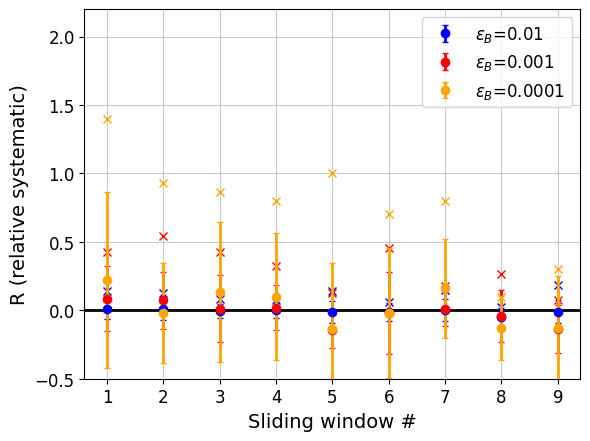

In [39]:
folder = general_directory+"IAD_half_without_4/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=[0,0,0])
IAD_error = np.mean(rel_error,axis=(1,2))

plotting_error(rel_error, "IAD_without", min=min_error, max=max_error)
print("alpha =", IAD_error)
print("alpha_std =", np.std(rel_error, axis=(1,2)))

IAD_stat = np.mean(exp,axis=(1,2))
IAD_sys = np.std(rel_error, axis=(1,2))
print("sys_err/stat_err =",IAD_stat)

Indeed, a good agreement with the null hypothesis is found.

## $\Delta R$ runs

/hpcwork/zu992399/bumphunt_paper/cathode_without_DR_randDE_avg/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


alpha = [0.19771609 0.27910638 0.55835798]
alpha_std = [0.06308535 0.14371803 0.53969443]
sys_err/stat_err = [0.02942294 0.09303302 0.29395057]


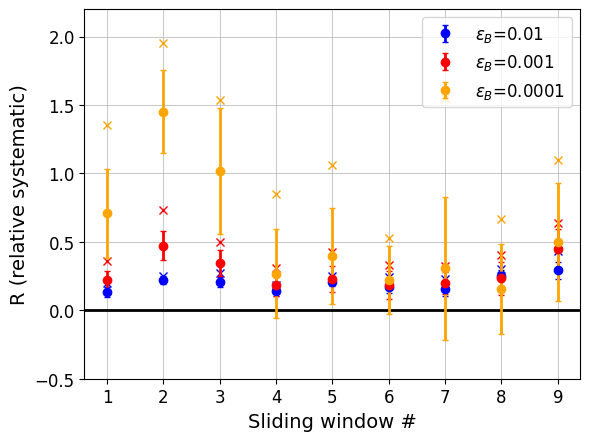

In [46]:
folder = general_directory+"cathode_without_DR_randDE_avg/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder)
cathode_DR_error = np.mean(rel_error,axis=(1,2))
plotting_error(rel_error, "cathode_DR_without", min=min_error, max=max_error)

cathode_DR_stat = np.mean(exp,axis=(1,2))
cathode_DR_sys = np.std(rel_error, axis=(1,2))
print("alpha =",cathode_DR_error)
print("alpha_std =", np.std(rel_error, axis=(1,2)))
print("sys_err/stat_err =",cathode_DR_stat)

/hpcwork/zu992399/bumphunt_paper/cathode_norm_DR_avg_oversampling4/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


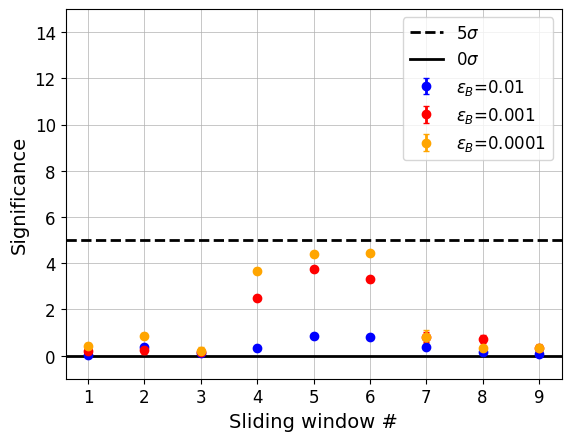

In [21]:
folder = general_directory+"cathode_norm_DR_avg_oversampling4/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cathode_DR_error)
plotting(rel_results, true_results, "cathode_norm_DR", min=min_sig, max = max_sig)

/work/zu992399/bumphunt_paper/cathode_without_Herwig_DR_randDE_avg_2/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


alpha = [0.19886136 0.25996586 0.22679873]
alpha_std = [0.04049649 0.13123241 0.38461343]
stat_error = [0.02928606 0.09260013 0.29255154]


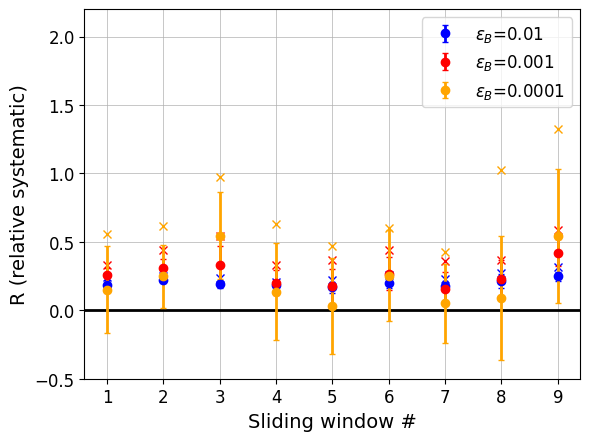

In [45]:
folder = general_directory_work+"cathode_without_Herwig_DR_randDE_avg_2/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder)
cathode_herwig_DR_error = np.mean(rel_error,axis=(1,2))
plotting_error(rel_error, "cathode_DR_without_herwig", min=min_error, max=max_error)
cathode_herwig_DR_stat = np.mean(exp,axis=(1,2))
cathode_herwig_DR_sys = np.std(rel_error, axis=(1,2))
print("alpha =",cathode_herwig_DR_error)
print("alpha_std =", np.std(rel_error, axis=(1,2)))
print("stat_error =",cathode_herwig_DR_stat)

/hpcwork/zu992399/bumphunt_paper/cathode_without_DR_randDE_avg/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


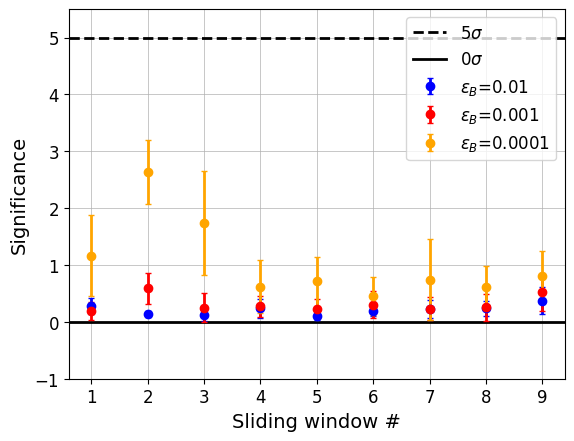

In [23]:
folder = general_directory+"cathode_without_DR_randDE_avg/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cathode_herwig_DR_error)
plotting(rel_results, true_results, "cathode_without_DR_pythia_herwig", min=min_sig, max = max_sig_no)

/hpcwork/zu992399/bumphunt_paper/cathode_norm_DR_avg_oversampling4/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


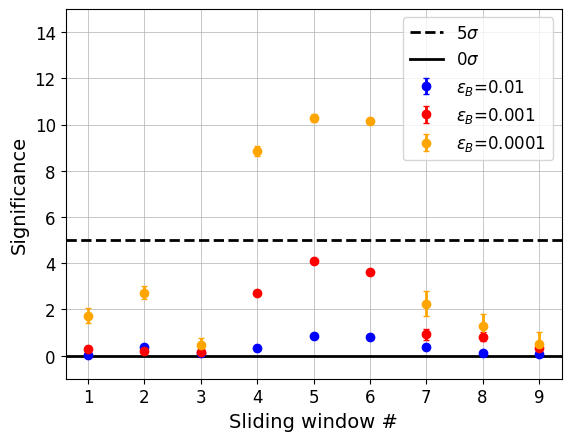

In [24]:
folder = general_directory+"cathode_norm_DR_avg_oversampling4/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cathode_herwig_DR_error)
plotting(rel_results, true_results, "cathode_norm_DR_pythia_herwig", min=min_sig, max = max_sig)

/hpcwork/zu992399/bumphunt_paper/cwola_without_DR/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


alpha = [0.74167407 0.85978875 0.91285586]
alpha_std = [0.11904818 0.25038342 0.76667959]
sys_err/stat_err = [0.04069738 0.12570735 0.34592745]


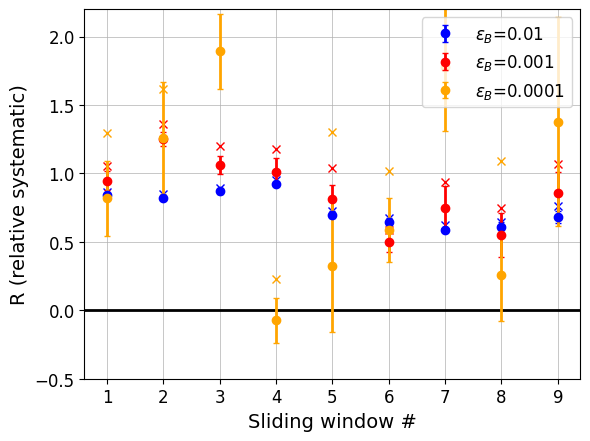

In [ ]:
folder = general_directory+"cwola_without_DR/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder)
cwola_DR_error = np.mean(rel_error,axis=(1,2))

plotting_error(rel_error, "cwola_DR_without", min=min_error, max=max_error)
cwola_DR_stat = np.mean(exp,axis=(1,2))
cwola_DR_sys = np.std(rel_error, axis=(1,2))
print("alpha =",cwola_DR_error)
print("alpha_std =", np.std(rel_error, axis=(1,2)))
print("sys_err/stat_err =",cwola_DR_stat)

/hpcwork/zu992399/bumphunt_paper/cwola_norm_DR/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


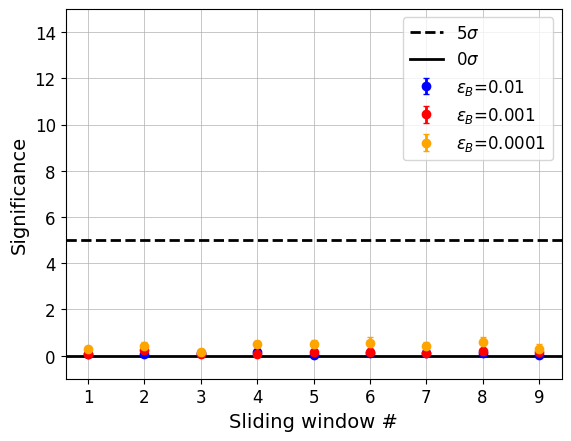

In [26]:
folder = general_directory+"cwola_norm_DR/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cwola_DR_error)
plotting(rel_results, true_results, "cwola_norm_DR", min=min_sig, max = max_sig)

/hpcwork/zu992399/bumphunt_paper/cwola_herwig_DR_without_2/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


alpha = [0.72917793 0.65731549 0.562888  ]
alpha_std = [0.06964362 0.18722315 0.47413199]
sys_err/stat_err = [0.0405332  0.12560472 0.34561306]


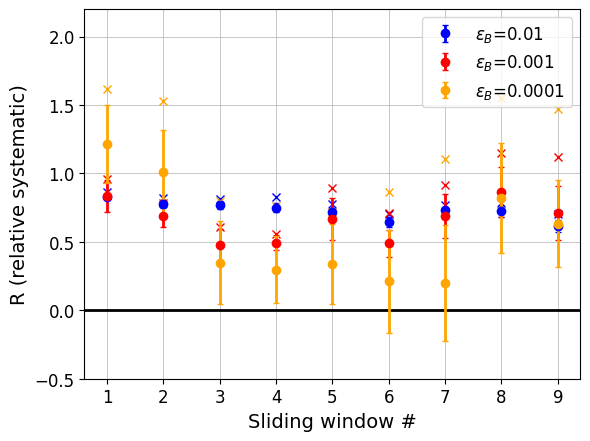

In [41]:
folder = general_directory+"cwola_herwig_DR_without_2/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder)
cwola_herwig_DR_error = np.mean(rel_error,axis=(1,2))

plotting_error(rel_error, "cwola_DR_without_herwig", min=min_error, max=max_error)
cwola_herwig_DR_stat = np.mean(exp,axis=(1,2))
cwola_herwig_DR_sys = np.std(rel_error, axis=(1,2))
print("alpha =",cwola_herwig_DR_error)
print("alpha_std =", np.std(rel_error, axis=(1,2)))
print("sys_err/stat_err =",cwola_herwig_DR_stat)

/hpcwork/zu992399/bumphunt_paper/cwola_without_DR/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


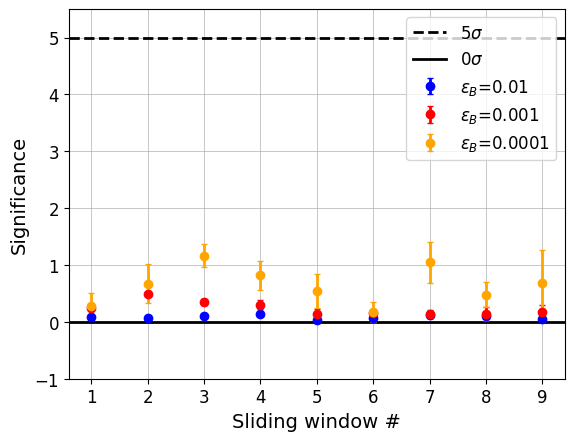

In [28]:
folder = general_directory+"cwola_without_DR/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cwola_herwig_DR_error)
plotting(rel_results, true_results, "cwola_without_DR_pythia_herwig", min=min_sig, max = max_sig_no)

/hpcwork/zu992399/bumphunt_paper/cwola_norm_DR/


/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ln2 = 2 * b**2 / err**2 * np.log(ln2)
/tmp/zu992399/login23-1_26381/ipykernel_62107/237232679.py:19: RuntimeWarning: invalid value encountered in multiply
  ln2 = 2 * b**2 / err**2 * np.log(ln2)


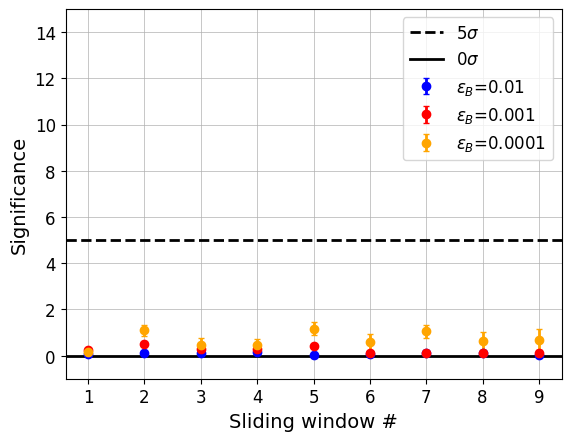

In [29]:
folder = general_directory+"cwola_norm_DR/"
results, rel_results, true_results, rel_error, exp = bump_hunt(folder, err=cwola_herwig_DR_error)
plotting(rel_results, true_results, "cwola_norm_DR_pythia_herwig", min=min_sig, max = max_sig)

In [30]:
print(cwola_DR_stat)
print(cathode_DR_stat)
print(cwola_stat)
print(cathode_stat)
print(IAD_stat)

print((cwola_DR_error-cwola_herwig_DR_error)/np.sqrt(cwola_DR_stat**2))

[0.04069738 0.12570735 0.34592745]
[0.02942294 0.09303302 0.29395057]
[0.04069738 0.12570735 0.34592745]
[0.02942294 0.093033   0.29394902]
[0.05837543 0.17705341 0.4198579 ]
[0.30705016 1.61067161 1.01167994]


In [31]:
def error_printing(sys, stat):
    list = [str(np.round(sys[i],2))+" & "+ str(np.round(stat[i],2)) for i in range(3)]
    return list[0] + "&" + list[1] + "&" + list[2] + " \\\ \hline"

In [32]:
print("IAD &", error_printing(IAD_error, IAD_stat))
print("Cathode &", error_printing(cathode_error, cathode_stat))
print("CWoLa &", error_printing(cwola_error, cwola_stat))
print("Cathode $\Delta R$ &", error_printing(cathode_DR_error, cathode_DR_stat))
print("CWoLa $\Deltat R$ &", error_printing(cwola_DR_error, cwola_DR_stat))

IAD & -0.01 & 0.06&-0.02 & 0.18&0.02 & 0.42 \\ \hline
Cathode & 0.13 & 0.03&0.25 & 0.09&0.8 & 0.29 \\ \hline
CWoLa & 0.14 & 0.04&0.16 & 0.13&0.2 & 0.35 \\ \hline
Cathode $\Delta R$ & 0.2 & 0.03&0.28 & 0.09&0.56 & 0.29 \\ \hline
CWoLa $\Deltat R$ & 0.74 & 0.04&0.86 & 0.13&0.91 & 0.35 \\ \hline


In [53]:
def error_herwig_printing(sys, sys_no, stat):
    dev = (sys-sys_no)/np.sqrt(stat**2+sys_no**2)
    list = [str(np.round(sys[i],2))+" & "+ str(np.round(stat[i],2))+  " & " + str(np.round(dev[i], 1)) for i in range(3)]
    return list[0] + "&" + list[1] + "&" + list[2] + " \\\ \hline"

In [54]:
print("Cathode &", error_herwig_printing(cathode_error, cathode_herwig_error, cathode_herwig_stat))
print("CWoLa &", error_herwig_printing(cwola_error, cwola_herwig_error, cwola_herwig_stat))
print("Cathode $\Delta R$ &", error_herwig_printing(cathode_DR_error, cathode_herwig_DR_error, cathode_herwig_DR_stat))
print("CWoLa $\Delta R$ &", error_herwig_printing(cwola_DR_error, cwola_herwig_DR_error, cwola_DR_stat))

Cathode & 0.13 & 0.03 & 0.5&0.25 & 0.09 & 0.5&0.8 & 0.29 & 1.3 \\ \hline
CWoLa & 0.14 & 0.04 & -0.0&0.16 & 0.13 & 0.3&0.2 & 0.35 & 0.4 \\ \hline
Cathode $\Delta R$ & 0.2 & 0.03 & -0.0&0.28 & 0.09 & 0.1&0.56 & 0.29 & 0.9 \\ \hline
CWoLa $\Delta R$ & 0.74 & 0.04 & 0.0&0.86 & 0.13 & 0.3&0.91 & 0.35 & 0.5 \\ \hline


In [48]:
def error_sys_printing(sys, sys_err, stat):
    #dev = (sys_no-sys)/sys#np.sqrt(stat**2+sys**2)
    list = [str(np.round(sys[i],2))+  " & " + str(np.round(sys_err[i], 2))+" & "+ str(np.round(stat[i],2)) for i in range(3)]
    return list[0] + "&" + list[1] + "&" + list[2] + " \\\ \hline"

In [49]:
print("IAD &", error_sys_printing(IAD_error, IAD_sys, IAD_stat))
print("Cathode &", error_sys_printing(cathode_herwig_error, cathode_herwig_sys, cathode_herwig_stat))
print("CWoLa &", error_sys_printing(cwola_herwig_error, cwola_herwig_sys, cwola_herwig_stat))
print("Cathode $\Delta R$ &", error_sys_printing(cathode_herwig_DR_error, cathode_herwig_DR_sys, cathode_herwig_DR_stat))
print("CWoLa $\Delta R$ &", error_sys_printing(cwola_herwig_DR_error, cwola_herwig_DR_sys, cwola_DR_stat))

IAD & -0.01 & 0.07 & 0.06&-0.02 & 0.21 & 0.18&0.02 & 0.45 & 0.42 \\ \hline
Cathode & 0.09 & 0.04 & 0.03&0.16 & 0.11 & 0.09&0.27 & 0.37 & 0.29 \\ \hline
CWoLa & 0.14 & 0.05 & 0.04&0.11 & 0.18 & 0.13&0.05 & 0.32 & 0.35 \\ \hline
Cathode $\Delta R$ & 0.2 & 0.04 & 0.03&0.26 & 0.13 & 0.09&0.23 & 0.38 & 0.29 \\ \hline
CWoLa $\Delta R$ & 0.73 & 0.07 & 0.04&0.66 & 0.19 & 0.13&0.56 & 0.47 & 0.35 \\ \hline
